<img src="imgs/CustomerSegmentation.png" width=1080>Credits: DALL-E</img>

# Introduction

In this project we'll talk about Customer Segmentation, an essential machine learning task used by companies to get insights about their clients base, like their needs, which groups should marketing programs be focused on, what preferences these groups have, how to engage new clients and so on.

## Required packages

- Numpy
- Pandas
- Scikit-Learn
- Matplotlib
- Seaborn
- Kaggle API (optional)

## Imports

In [1]:
import os

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## What is Customer Segmentation and why to use it?

Customer Segmentation is the process of dividing customers into groups based on common characteristics. A company might segment customers according to a wide range of factors: age, gender, marital status, purchase history, location (urban, suburban, rural), etc. Segmentation allows marketers to better tailor their marketing efforts to various audience subsets. Those efforts can relate to both communications and product development. Specifically, segmentation helps a company:

- Create and communicate targeted marketing messages that will resonate with specific groups of customers, but not with others (which will receive messages tailored to their needs and interests, instead).
- Select the best communication channel for the segment. e.g.: email, social media posts, radio advertising,etc.
- Identify ways to improve products or new product or service opportunities.
- Establish better customer relationships.
- Test pricing options.
- Focus on the most profitable customers.
- Improve customer cross-sell, i.e.: when we offer products that complements the products that customers are used to purchase.

Companies employing customer segmentation operate under the fact that every customer has its specific needs, and that marketing efforts would be better served if they target specific, smaller groups with relevant messages. Companies also hope to gain a deeper understanding of their customer's preferences and needs with the idea of discovering what each segment finds most valuable to more accurately tailor marketing materials toward that segment.

## Dataset Description

For this project we'll use the [Mall Costumer Segmentation Data](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python), a dataset created with the sole purpose of learning the concepts of Customer Segmentation using Machine Learning.

The data is composed by the following variables:

- **CustomerID**: Unique ID assigned to the customer
- **Gender**: Gender of the customer
- **Age**: Age of the customer
- **Annual Income (R$)**: Annual Income of the customer
- **Spending score (1-100)**: Score assigned by the mall based on the customer behavior and spending nature.

## Exploratory Data Analysis

Let's begin by downloading our data. Here I'll use the [kaggle API](https://github.com/Kaggle/kaggle-api) package, but you are free to donwload it manually or by other means.

In [2]:
if not os.path.isfile("Mall_Customers.csv"):
    !kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python
    !unzip customer-segmentation-tutorial-in-python.zip
    !rm customer-segmentation-tutorial-in-python.zip

In [3]:
customer_data = pd.read_csv("Mall_Customers.csv", index_col="CustomerID")
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [4]:
customer_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


As we can see, the data consists of 200 entries. The **Gender** feature was loaded as the `object` data type, as it contains string values. All other features were loaded as `integer` data type.

Let's check for missing values

In [5]:
missing_info = customer_data.isna().sum().to_frame()
missing_info.columns = ["NA count"]
missing_info

,NA count
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


We don't have missing data. Good! For such a small dataset, missing values would be a problem.

Let's check some dataset statics

In [6]:
print("Numeric variables:")
display(customer_data.describe().T)
print("-" * 87)
print("Nominal variables:")
display(customer_data.describe(include="O").T)

Numeric variables:


,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


---------------------------------------------------------------------------------------
Nominal variables:


,count,unique,top,freq
Gender,200,2,Female,112


We can conclude that:
 - **Gender** is a nominal feature only 2 possible values: *Male* and *Female*.
 - **Age** and **Spending Score (1-100)** are numeric discrete features, as both can only assume a finite set of values. **Age** ranges from 18 to 70, and **Spending Score (1-100)** ranges from 1 to 100
- **Annual Income (k\\$)** is a numeric continuous feature, as it can assume virtually any value.

## Features Analysis

Now we'll analyze each feature distribution to extract any information tha may be relevant for our segmentation approach.

### Gender Distribution

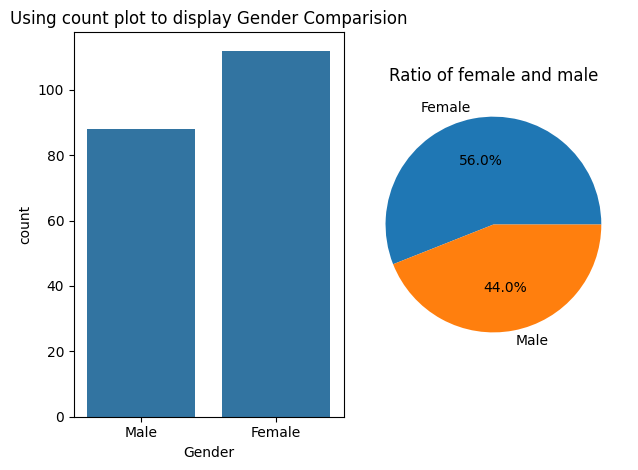

In [7]:
_, (ax1, ax2) = plt.subplots(ncols=2)

sns.countplot(x="Gender", data=customer_data, ax=ax1)
ax1.set_title("Using count plot to display Gender Comparision")

customer_data.groupby("Gender").size().plot.pie(autopct="%.1f%%", ax=ax2)
ax2.set_title("Ratio of female and male")
ax2.set_ylabel("")

plt.tight_layout()

As said before, the **Gender** variable is a *binary* variable, and it's value can be either *Male* of *Female*. One can also note that there are sightly more *Female* entries than *Male*.

### Distribution plots

The following variables are of continuous type, and we'll basically describe then using their histogram, density estimation functions and [box plots](https://seaborn.pydata.org/generated/seaborn.boxplot.html). We'll create a function that encapsulates the creation of those plots.

In [8]:
def distribution_plots(data, column, bins, color=None):
    _, (ax1, ax2) = plt.subplots(nrows=2)

    # Seaborn's histplot can combine a histogram and a density estimation function
    # in one single plot.
    sns.histplot(x=column, data=data, kde=True, bins=bins, color=color, ax=ax1)
    ax1.set_title(f"Distribution of {column} feature")

    sns.boxplot(x=column, data=data, color=color, ax=ax2)
    ax2.set_title(f"Boxplot for Descriptive Analysis of {column} feature")

    plt.tight_layout()

### Age Distribution

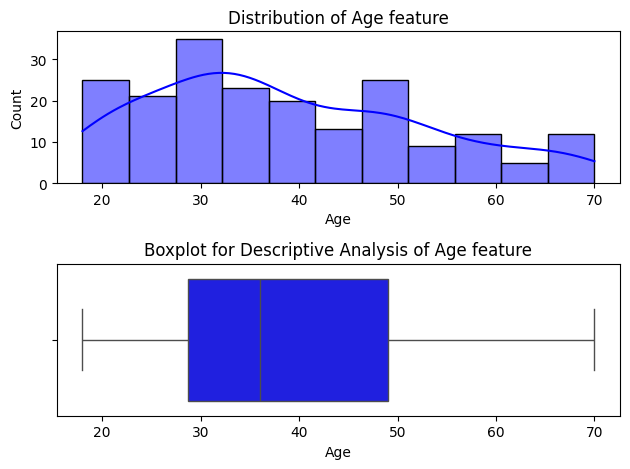

In [9]:
distribution_plots(customer_data, "Age", bins=11, color="blue")

As we can see, 50% of the customers have between 28 and 49 years old, and the age average is about 36 years. The younger customer and the older customer have 18 and 70 years old, respectively.

### Annual Income of the Customers

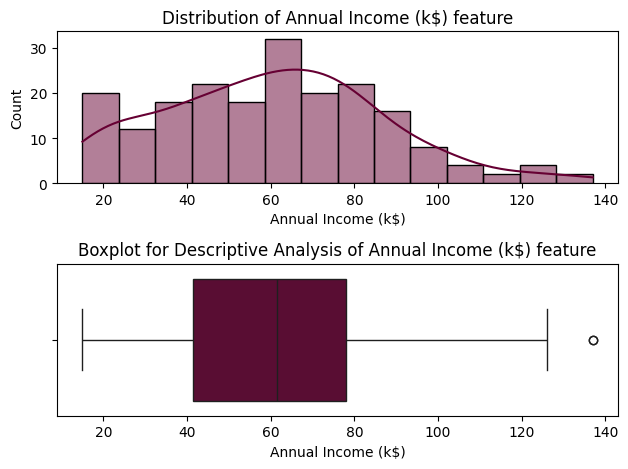

In [10]:
distribution_plots(customer_data, "Annual Income (k$)", bins=14, color="#660033")

From the descriptive analysis above, we can conclude that 50% of the consumers have annual income between 41,5 k$ and 78 k$, and the average income is about 61,5 k$. The minimum user income is of 15 k$ and the maximum is of 137 k$.

We can also see that the value of 137 k$ seems to be an outlier.

### Spending Score of the Customers

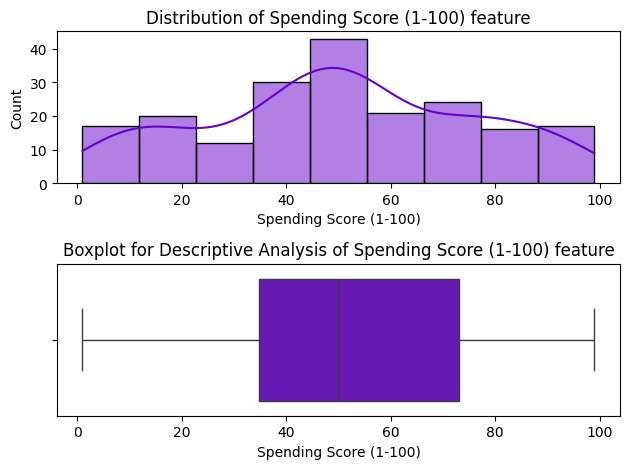

In [11]:
distribution_plots(customer_data, "Spending Score (1-100)", bins=9, color="#6600cc")

50% of the customers have the score between 35 and 73, with the mean score of approximately 50.

## Customer Base Clustering

Gennearally speaking, customer segmentation requires a company to gather specific information/data about customers, analyze it and identify patterns that can be used to create the segments. Typical information-gathering methods include:

- Face-to-face or telephone interviews
- Surveys
- General research using published information about market categories
- Focus groups

The gathered data then is analyzed by marketing specialists with the aid of other professionals, like designers, entrepreneurs and, of course, data scientists.

As we already have customer data, we'll skip all complexities of a marketing campaign and focus on a simple machine learning approach using the **k-means clustering algorithm**.

### K-means Algorithm

The most common k-means clustering algorithm (a.k.a. naive k-means) is a **unsupervised learning** technique that consists in cluster similar data based on the **Euclidean Distance** of each data point, or observations, to its closes *cluster centroid*. The algorithm aims to minimize the distances between *cluster centroids* and their assigned observations and maximize *inter-cluster distances*.

![Clustering example](imgs/clustering_example.png)

We can summarize the k-means algorithm as:

1. The number $ k $ of clusters to be created is chosen.
2. The algorithm randomly choose $ k $ observations as initial cluster centroids.
3. The Euclidean Distances between all observations and the cluster centroids are computed.
4. Each observation is assigned to its closest cluster.
5. Each cluster centroid is updated with the mean point of all cluster observations.
6. Repeat steps **3** to **5** until convergence (i.e: maximum number of iterations, sum of squared observation-cluster distances, etc.)

These steps are executed a bunch of times for different initial centroids. The execution that results in *minimum difference of variation between clusters* is chosen as the best one.

The k-means algorithm clusters data by trying to separate samples in $ k $ groups of equal variance, minimizing a criterion know as the **inertia** or **intra-cluster sum-of-squares**, which is mathematically defined as:
$$
\sum_{i=0}^k \min_{\mu_j \in C} (||x_i - \mu_j||^2)
$$
where $ x_i $ is the components vector of the $ i $-th observation and $ \mu_j $ is the centroid of the $ j $-th cluster. Inertia can be interpreted as a measure of how internally coherent clusters are.

### Determining the Optimal Number of Clusters

Now that we know the basics of k-means clustering, there is one question left: how do we choose the number $ k $ of clusters?

Depending of the problem statement we could set $ k $ to an arbitrary value. For a set of cloth items we could, for example, cluster them into 3 groups by their sizes: Big, Medium and Small.

In cases where the value of $ k $ was not made clear by the business logic, one can use a value search method. In this post we'll present two of the most popular:

- Elbow method
- Silhouette method

#### Elbow Method

The elbow method consists in plotting the **inertia** of clusterings for several values of $ k $.

The following function returns the intertia for a clustering. It basically uses the Scikit-Learn library to create the cluster then retrieves the inertia of the clustering.

In [12]:
def get_clustering_inertia(k, data):
    kmeans = KMeans(
        n_clusters=k,
        algorithm="lloyd",  # we'll use the classical EM-style algorithm. Refer to sklearn's user guide: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
        n_init=100,
        max_iter=100,
        random_state=42,  # use this to get reproducible results
    ).fit(data)
    return kmeans.inertia_

To be used by the k-means algorithm, all variables must be of *numeric* type. As **Gender** contains only two values, we'll replace all "Male" occurrences by 0 and "Female" occurrences by 1.

In [13]:
customer_data["Gender"] = customer_data["Gender"].replace({"Male": 0, "Female": 1})

/tmp/ipykernel_89189/1845303345.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_data["Gender"] = customer_data["Gender"].replace({"Male": 0, "Female": 1})


Now we can proceed with our analysis by retrieving the inertia for a set of clusterings with different values for $k$.

In [14]:
inertia_values = [get_clustering_inertia(k, customer_data.iloc[:, 1:]) for k in range(1, 11)]

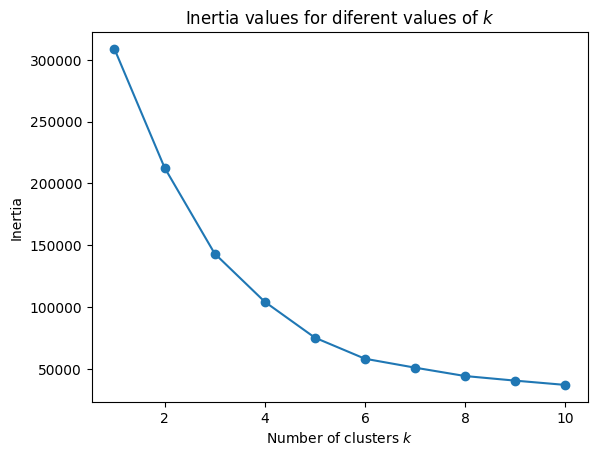

In [15]:
_, ax = plt.subplots()
plt.plot(range(1, 11), inertia_values, "o-")
plt.title("Inertia values for diferent values of $ k $")
plt.xlabel("Number of clusters $ k $")
plt.ylabel("Inertia")
plt.show()

We'll choose the value of $ k $ clusters which if we add another cluster it doesn't result in a relevant improvement. In our case, the value of **6** satisfy this condition.

#### Average Solhouette Method

The Silhouette method provides a succinct graphical representation of how well each observation has been classified.

The silhouette coefficient is defined as:
$$
s = \frac{b - a}{max(a, b)}
$$
where $ a $ is the means distance between a sample and all other observations in the same class, and $ b $ is the mean distance between a sample and all other observations in the next nearest cluster. The silhouette coefficient is a measure of how similar an observation is to its own cluster compared to other clusters. It ranges from -1 to +1, where a high values indicates that the observation is well matched to its own cluster and poorly matched to neighboring clusters.

Our approach will be simple: we'll compute the average silhouette coefficient of several clustering strategies using different $ k $ values. Generally speaking, if we obtain a high average value it means that we have good clustering.

For a given clustering model, the following function:
- Computer the silhouette coefficient for each sample.
- Plot a the samples' silhouette coefficients as a graphical representation of how well those samples are matched to their respective clusters.
- Returns the average silhouette coefficients for the model.

In [16]:
def plot_silhouettes(
    clustering_model: KMeans, data: np.ndarray, labels: np.ndarray, ax=None
) -> float:
    n_clusters = len(clustering_model.cluster_centers_)

    samples_coeffs = silhouette_samples(data, labels)

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    ax = plt.gca() if ax is None else ax
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    y_lower = 10
    for i, color in zip(range(n_clusters), colors):
        ith_cluster_coeffs = samples_coeffs[labels == i]
        ith_cluster_coeffs.sort()

        size_cluster_i = ith_cluster_coeffs.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_coeffs,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    silhouette_avg = silhouette_score(data, labels)

    ax.set_title(f"Silhouette plot for {n_clusters} clusters")
    ax.set_xlabel(f"Silhouette coefficient values (Avg = {silhouette_avg:3.2f})")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    return silhouette_avg

For each cluster, the samples coefficients are sorted and plotted, forming a **region** for the cluster. Basically, the less "jagged", longer and similar those clusters regions are the better.

The sklearn's [silhouette_samples](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#) function computes the silhouette coefficients for for each data sample and its assigned cluster centroid. [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) returns the average silhouette coefficient for a clustering given the data and it's assigned cluster centroids.

Now, we'll analyze the silhouette plots for a set of clustering models.

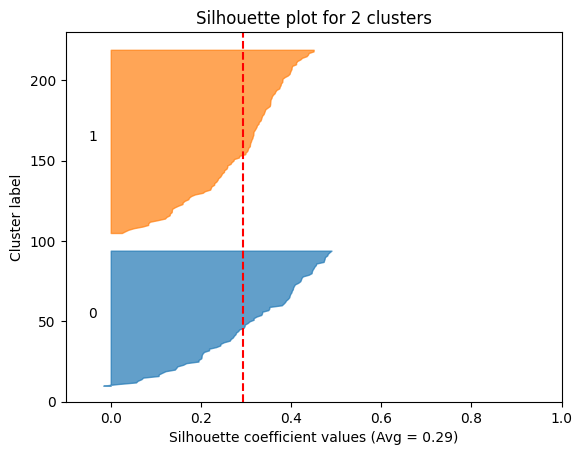

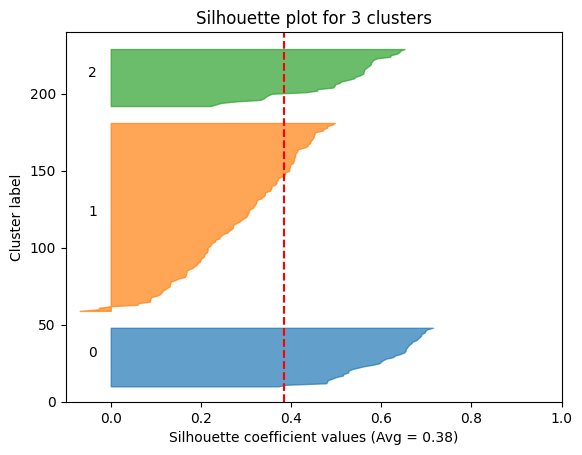

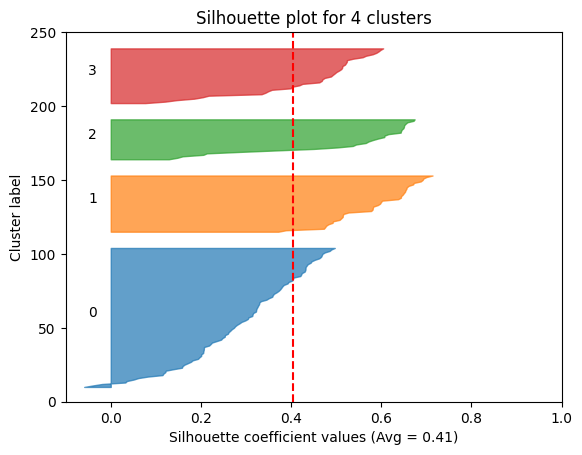

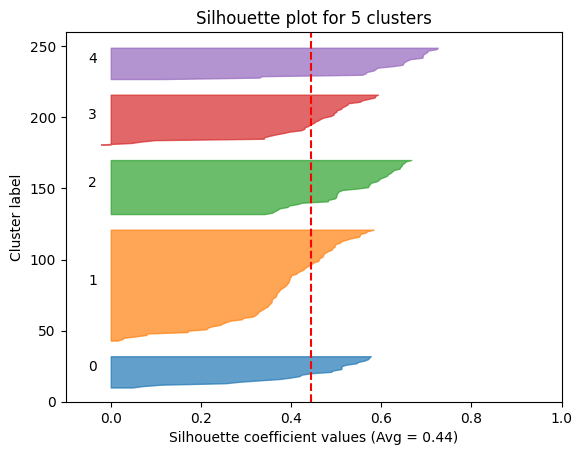

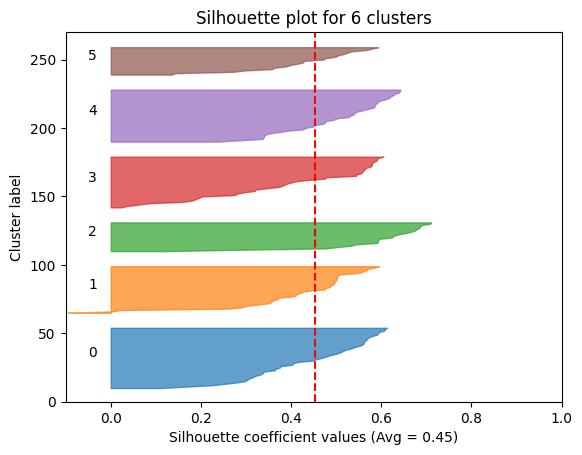

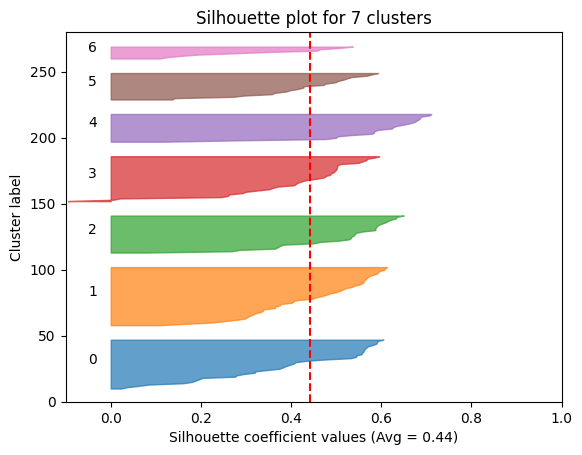

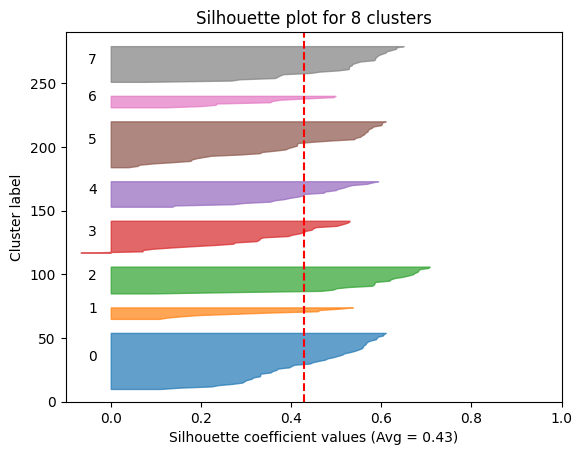

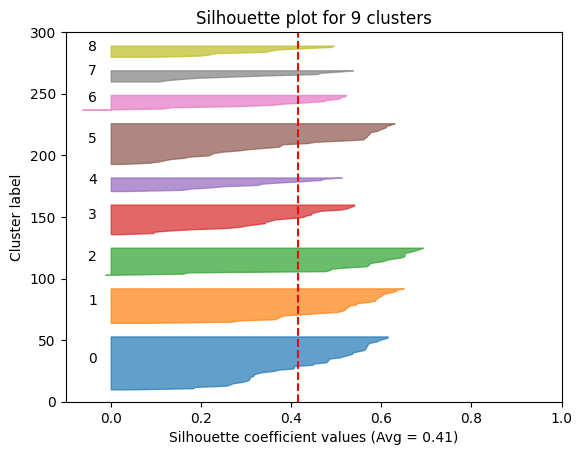

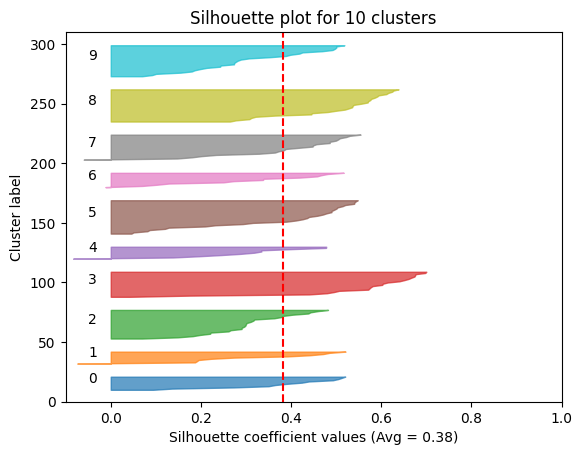

In [17]:
silhouette_avgs = []

for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k, max_iter=100, algorithm="lloyd", n_init=100, random_state=42
    ).fit(customer_data)
    cluster_labels = kmeans.predict(customer_data)

    _, ax = plt.subplots()
    si = plot_silhouettes(kmeans, customer_data, labels=cluster_labels, ax=ax)
    silhouette_avgs.append(si)

silhouette_avgs = np.array(silhouette_avgs)

The red lines of each plot represents the average silhouette for the model. We can also see that some samples of some cluster fall outside the range **0 to 1**, indicating that these samples poorly match to the clusters that they were assign to (a.k.a.: *outliers*).

From the figures above, we can see, by checking both the average silhouette coefficient value and the shape of the **clusters' regions**, that the model for $k$=6 is the best clustering. This conclusion is further supported by plotting the average coefficients for each model.

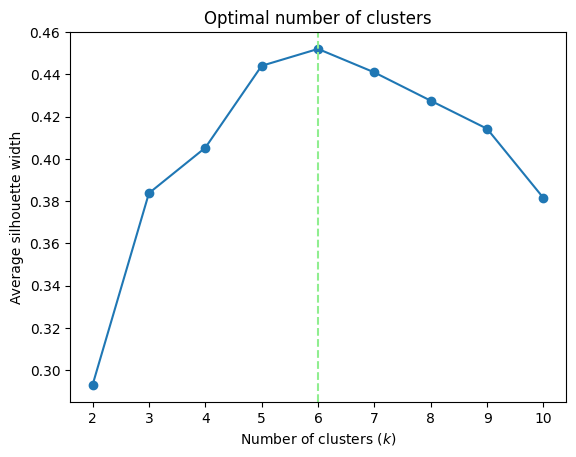

In [18]:
_, ax = plt.subplots()
ax.plot(range(2, 11), silhouette_avgs, "o-")
ax.axvline(x=silhouette_avgs.argmax() + 2, color="lightgreen", linestyle="--")
ax.set_title("Optimal number of clusters")
ax.set_xlabel("Number of clusters ($ k $)")
ax.set_ylabel("Average silhouette width")
plt.show()

As we can see, this plot confirms that the optimal number of clusters is **6**.

### Clustering Visualization

As the dataset is composed of 4 variables, it is impossible for us to visualize the clustering in such space. So we need a way to visualize this data in a **reduced space**. For this, we'll used the so called **Principal Component Analysis** (**PCA**), a statistical technique that decompose a multivariate dataset in a set of **principal components**: successive orthogonal components that explain the data's variance. The first principal component can be defined as a direction of maximum variance of the projected data, while the second component can be defined as a direction of the second maximum variance of the projected data, the third component is the direction of the third maximum variance, and so on.

First, we compute the optimal clustering.

In [19]:
n_clusters = 6
optimal_model = KMeans(
    n_clusters=n_clusters, max_iter=100, algorithm="lloyd", n_init=100, random_state=42
).fit(customer_data)
cluster_labels = optimal_model.predict(customer_data)

Next we fit a [sklearn's PCA transformer](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and project the data to this reduced space.

In [20]:
from sklearn.decomposition import PCA

# We'll use only two princiapl Components
pc_reduced = PCA(n_components=2, random_state=42).fit(customer_data)

reduced_data = pc_reduced.transform(customer_data)
reduced_data.shape

(200, 2)

The 4D variable space was transformed to a 2D space, which we can use to visualize the clustering results.

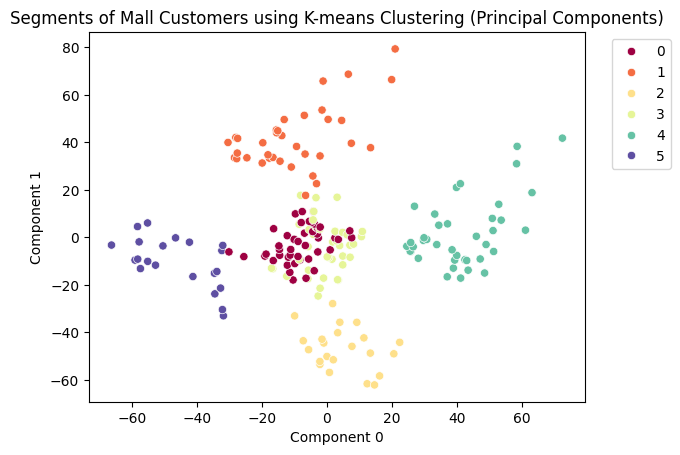

In [21]:
cmap = matplotlib.colormaps["Spectral"]

ax = sns.scatterplot(
    x=reduced_data[:, 0], y=reduced_data[:, 1], hue=cluster_labels, palette=cmap
)
ax.set_title(
    "Segments of Mall Customers using K-means Clustering (Principal Components)"
)
ax.set_xlabel("Component 0")
ax.set_ylabel("Component 1")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

As we can see, clusters 0, 1, 2 and 4 are well defined and clusters 3 and 5 are a bit mixed.

## Visualizing variables with high variation

The above plot can show clearly how effective the clustering model is, but we cannot actually extract an useful information from it. It would be better to see the clustering results using a subset of the original components.

Let's fit another PCA transformer, but this time we'll compute components for the full 4D space.

In [22]:
# When we not supply n_components, the pricipal components are computed
# for the full feature space.
pc_full = PCA(random_state=42).fit(customer_data)

The PCA transformer computes the components and stores them in the `components_` attribute, sorted by the amount of variation. The amounts of variation of the components are stored in the `explained_variance_` attribute.

In [23]:
pc_full.explained_variance_

array([7.00264432e+02, 6.84331841e+02, 1.67228881e+02, 2.45498578e-01])

The amount of variation can be interpreted as a measure of *how much information* is contained in data. High variation means more information. So, now we can tell which dataset's features can better explain the information in data.

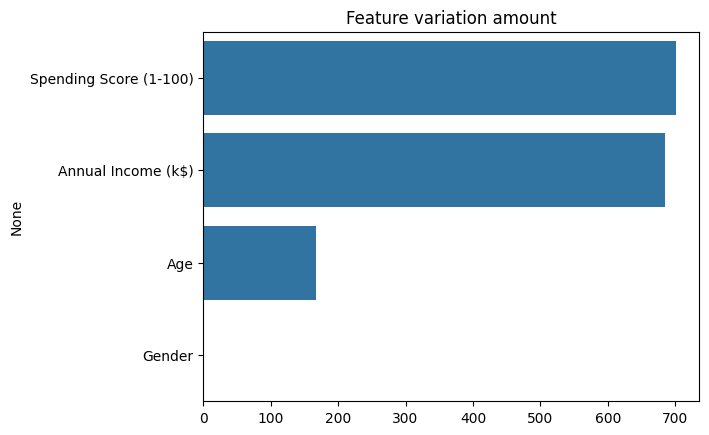

In [24]:
component_order = pc_full.explained_variance_.argsort()
var_sorted_columns = customer_data.columns[component_order]
var_sorted_columns

ax = sns.barplot(y=var_sorted_columns, x=pc_full.explained_variance_)
plt.title("Feature variation amount");

As we can see, "Spending Score (1-100)" and "Annual Income (k$)" are the variables that holds most of the information in dataset. We can visualize the clustering results using only those variables.

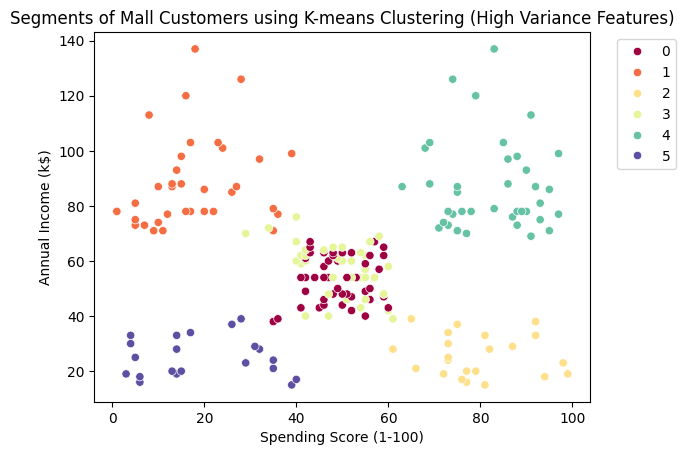

In [25]:
cmap = matplotlib.colormaps["Spectral"]

ax = sns.scatterplot(
    x=var_sorted_columns[0],
    y=var_sorted_columns[1],
    data=customer_data,
    hue=cluster_labels,
    palette=cmap,
)
ax.set_title(
    "Segments of Mall Customers using K-means Clustering (High Variance Features)"
)
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

We can clearly conclude that the clustering methodology successfully isolated 4 groups:
- **Group 0**: represents customers with low Spending Scores and low Annual Incomes
- **Group 1**: represents customers with high Spending Scores and low Annual Incomes
- **Group 4**: represents customers with high Spending Scores and high Annual Incomes
- **Group 2**: represents customers with low Spending Scores and high Annual Incomes

Groups **3** and **5** represents customers with both medium Spending Scores and medium Annual Incomes. These groups seems to be mixed in this reduced space, but remember that we took only the two  most informative features in consideration.

# Conclusion

Modern business thrive by delivering highly personalized services to their customers, which would not have been possible without some form of customer categorization or segmentation. In doing so, organizations can easily structure their services and products around their customers while targeting them to drive more revenue.

In this post we presented a simple approach to Customer Segmentation using the k-means algorithm. The clustering is based on user features, like age, gender, income and purchase history. We also presented how to use the PCA transform to reduce the data feature space to better visualize how data is clustered.

# References

Most of the methodology present in this post was adapted from Data Flair's [post](https://data-flair.training/blogs/data-science-projects-code/). Thanks to Data Flair's team for sharing their knowledge.

Other useful links:
- Irfan Alghani Khalid's post on [Customer Segmentation in Python](https://towardsdatascience.com/customer-segmentation-in-python-9c15acf6f945)
- GeeksforGeeks's post on [Elbow Method for optimal value of k in KMeans](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)
- Wikipedia's page about the [Silhouette Method](https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- Sklearn's [page](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on Selecting the number of clusters with silhouette analysis on KMeans clustering
- Sklearn's [page](https://scikit-learn.org/stable/modules/clustering.html) on clustering
- [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) by Trevor Hastie, Robert Tibshirani and Jerome Friedman